In [20]:
from cvxopt import matrix, solvers
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random
import decimal
import copy
from IPython.display import clear_output
solvers.options['show_progress'] = False

# Planning horizon = 1 (Works ✅)

In [21]:
class MPC:
    def __init__(self, agent_id, i_state, g_state, vg, wg, p_horizon, u_horizon):
        self.agent_id = agent_id # id of the agent
        self.agent_radius = 2
        self.i_state = np.array(i_state) # start state
        self.g_state = np.array(g_state) # goal state
        self.c_state = i_state # current state
        self.vg = vg  # initial velocity
        self.wg = wg # initial angular velocity
        self.p_horizon = p_horizon # planning horizon
        self.u_horizon = u_horizon # update horizon
        self.vl = 0 # last known velocity of the agent
        self.wl = 0 # last known angular velocity of the agent
        self.dt = 0.1
        self.v_list = [0]
        self.agent_radius = 2
        
    def pred_controls(self):
        # define the cost function here and optimize the controls to minimize it
        a = math.cos(self.c_state[2] + self.wg*self.dt)*self.dt
        b = self.vg*math.sin(self.c_state[2] + self.wg*self.dt)*self.dt**2
        c = self.c_state[0] + self.wg*b
        d = math.sin(self.c_state[2] + self.wg*self.dt)*self.dt
        e = self.vg*math.cos(self.c_state[2] + self.wg*self.dt)*self.dt**2
        f = self.c_state[1] - self.wg*e
        A = a**2 + d**2
        B = -a*b + d*e
        C = b**2 + e**2 + self.dt**2 
        P = 2*matrix([ [A, B], [B, C] ],tc='d')
        
        q_1 = 2*a*c - 2*self.g_state[0]*a + 2*d*f - 2*d*self.g_state[1]
        q_2 = -2*b*c + 2*self.g_state[0]*b + + 2*e*f - 2*e*self.g_state[1] + 2*self.i_state[2]*self.dt - 2*self.g_state[2]*self.dt
        q = matrix([q_1, q_2],tc='d')
#         return P, q
        # Constraints
        v_ub = 10
        v_lb = 0
        w_ub = 0.5
        w_lb = -0.5
        g_mat = np.array([[0,-1],[-1,0],[1,0],[0,1],[1,0],[-1,0],[0,1],[0,-1]])
        h = matrix(np.array([w_ub, 0, v_ub, w_ub, self.vg+5,-(self.vg-5),self.wg+0.1,-(self.wg-0.1)]),tc='d')
        G = matrix(g_mat,tc='d')
        sol=solvers.qp(P, q, G, h)
        v_new = sol['x'][0] #vd
        w_new = sol['x'][1] #wd
        diff_v = v_new - self.vg
        diff_w = w_new - self.wg
        self.vg = v_new
        self.wg = w_new
        self.vl = self.vg
        self.wl = self.wg
        
    def non_hol_update(self):
        self.c_state[2] = self.c_state[2] + self.wg*self.dt
        self.c_state[0] = self.c_state[0] + self.vg*math.cos(self.c_state[2])*self.dt
        self.c_state[1] = self.c_state[1] + self.vg*math.sin(self.c_state[2])*self.dt
        
    def draw_circle(self):
        th = np.arange(0,2*np.pi,0.01)
        xunit = self.agent_radius * np.cos(th) + self.c_state[0]
        yunit = self.agent_radius * np.sin(th) + self.c_state[1]
        return xunit, yunit      

In [22]:
p_horizon = 1
u_horizon = 1
vg = 10 #random.random()
wg = 0.1 #random.random()
a = MPC(1, [0,0,np.deg2rad(45)],[80,50,np.deg2rad(45)], vg, wg, p_horizon, u_horizon)

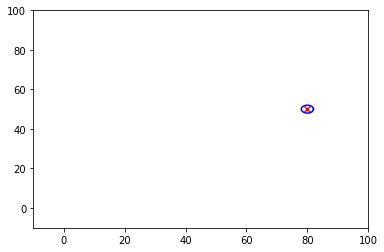

<Figure size 432x288 with 0 Axes>

In [23]:
th = 0.5
timeout = 150
while( (np.linalg.norm(a.c_state-a.g_state)>th) and timeout>0):
    
    a.pred_controls()
    a.v_list.append(a.vg)
#     print("pause")
#     time.sleep(10)
    a.non_hol_update()
    clear_output(wait=True)
    x,y = a.draw_circle()
    plt.plot(x,y,'b')
    plt.scatter(a.g_state[0],a.g_state[1],marker='x', color='r')
    plt.plot([a.c_state[0],a.g_state[0]],[a.c_state[1],a.g_state[1]], linestyle='dotted', c='k')
    plt.show()
    plt.xlim([-10,100])
    plt.ylim([-10,100])
    
    timeout = timeout - a.dt
plt.clf()

# Planning horizon = t (Doesn't work ❌)

In [16]:
class Agent:
    def __init__(self, agent_id, i_state, g_state, vg, wg, p_horizon, u_horizon):
        # agent state
        self.agent_id = agent_id # id of the agent
        self.agent_radius = 2
        self.i_state = np.array(i_state) # start state
        self.g_state = np.array(g_state) # goal state
        self.c_state = i_state # current state
        # horizons
        self.p_horizon = p_horizon # planning horizon
        self.u_horizon = u_horizon # update horizon
        # initial guesses
        self.vg = matrix(vg)  # initial velocity
        self.wg = matrix(wg) # initial angular velocity
        # last known values
        self.vl = 0 # last known velocity of the agent
        self.wl = 0 # last known angular velocity of the agent
        # current values
        self.v = self.vl # current velocity
        self.w = self.wl # current angular velocity
        # dt
        self.dt = 0.1
        # lists to store vel and angular vel for debugging
        self.x_traj = []
        self.y_traj = []
        self.v_list = [self.v]
        self.w_list = [self.w]
#         self.prev_sol = matrix(np.random.random((2*p_horizon)))
        
    def get_P_q_x(self):
        
        P_x_ = np.ones((1,2*self.p_horizon))
        
        d_th = np.ones((1,self.p_horizon)) # wg1, wg1+wg2, wg1+wg2+wg3
        s = 0
        for i in range(self.p_horizon):
            s = s + self.wg[i]
            d_th[0,i] = s
        
        th_ = np.ones((1,self.p_horizon)) # th0+wg1*dt, th0+(wg1+wg2)*dt, th0+(wg1+wg2+wg3)*dt
        th_0 = self.c_state[2]   
        for i in range(self.p_horizon):
            th_[0,i] = th_0 + d_th[0,i]*self.dt
        
        d_x = np.ones((1,self.p_horizon)) # contains a, b, c
        for i in range(self.p_horizon):
            d_x[0,i] = np.cos(th_[0,i])*self.dt
        
        d_w = np.ones((1,self.p_horizon)) # contains d, e, f
        for i in range(self.p_horizon):
            d_w[0,i] = -self.vg[i]*np.sin(th_[0,i])*self.dt**2
            
        s_dw = np.ones((1,self.p_horizon)) # contains d+e+f, e+f, f
        for i in range(self.p_horizon):
            s_dw[0,i] = np.sum(d_w[0,i:self.p_horizon])
        
        P_x_[0,0:self.p_horizon] = d_x
        P_x_[0,self.p_horizon:] = s_dw
        
        P_x = P_x_.T@P_x_
        
        ### Solving for q_x
        q_x = np.ones((2*self.p_horizon))
        x_0 = self.c_state[0]
        v_sum = 0
        w_sum = 0
        for i in range(self.p_horizon):
#             v_sum = v_sum + self.vg[i]*d_x[0,i]
            w_sum = w_sum + self.wg[i]*s_dw[0,i]
            
        z = x_0 - w_sum - self.g_state[0]
        q_x[0:self.p_horizon] = 2*z*d_x
        q_x[self.p_horizon:] = 2*z*s_dw 
        return P_x, q_x
    
    def get_P_q_y(self):
        
        P_y_ = np.ones((1,2*self.p_horizon))
        
        d_th = np.ones((1,self.p_horizon)) # wg1, wg1+wg2, wg1+wg2+wg3
        s = 0
        for i in range(self.p_horizon):
            s = s + self.wg[i]
            d_th[0,i] = s
        
        th_ = np.ones((1,self.p_horizon)) # th0+wg1*dt, th0+(wg1+wg2)*dt, th0+(wg1+wg2+wg3)*dt
        th_0 = self.c_state[2]   
        for i in range(self.p_horizon):
            th_[0,i] = th_0 + d_th[0,i]*self.dt
        
        d_y = np.ones((1,self.p_horizon)) # contains a, b, c
        for i in range(self.p_horizon):
            d_y[0,i] = np.sin(th_[0,i])*self.dt
        
        d_w = np.ones((1,self.p_horizon)) # contains d, e, f
        for i in range(self.p_horizon):
             d_w[0,i] = self.vg[i]*np.cos(th_[0,i])*self.dt**2
            
        s_dw = np.ones((1,self.p_horizon)) # contains d+e+f, e+f, f
        for i in range(self.p_horizon):
            s_dw[0,i] = np.sum(d_w[0,i:self.p_horizon])
            
        
        P_y_[0,0:self.p_horizon] = d_y
        P_y_[0,self.p_horizon:] = s_dw
        
        P_y = P_y_.T@P_y_
        
        ### Solving for q_y
        q_y = np.ones((2*self.p_horizon))
        y_0 = self.c_state[1]
        w_sum = 0
        for i in range(self.p_horizon):
            w_sum = w_sum + self.wg[i]*s_dw[0,i]
            
        z = y_0 - w_sum - self.g_state[1]
        q_y[0:self.p_horizon] = 2*z*d_y
        q_y[self.p_horizon:] = 2*z*s_dw 
        
        return P_y, q_y
        
    def get_P_q_theta(self):
        P_theta = np.zeros((2*self.p_horizon,2*self.p_horizon))
        P_theta[self.p_horizon:,self.p_horizon:]=self.dt**2*np.ones((self.p_horizon,self.p_horizon))
        
        q_theta = np.zeros((2*self.p_horizon))
        theta_0 = self.c_state[2]
        theta_g = self.g_state[2]
        q_theta[self.p_horizon:]=2*(theta_0 - theta_g)*self.dt * np.ones((self.p_horizon))
    
        return P_theta, q_theta
        
    def pred_controls(self):
        # define the cost function here and optimize the controls to minimize it
#         tolerance = 999999
#         while(tolerance>=99999):
        diff_v = 999
        diff_w = 999
        tol = 1e-1
#         while (np.linalg.norm(np.array([diff_w,diff_v]))>tol):
        P_x, q_x = self.get_P_q_x()
        P_y, q_y = self.get_P_q_y()
        P_theta, q_theta = self.get_P_q_theta()

        P = 2*matrix(P_x + P_y + P_theta, tc='d')

        q = matrix(q_x + q_y + q_theta, tc='d')

        # Constraints
        v_bound = 5
        w_bound = 0.1
        v_ub = 10*np.ones((self.p_horizon,1))
        v_lb = 0*np.ones((self.p_horizon,1))
        w_ub = 0.5*np.ones((self.p_horizon,1))
        w_lb = -0.5*np.ones((self.p_horizon,1))

        h = matrix(np.concatenate((v_ub, v_lb, w_ub, w_lb, self.vg+v_bound, -(self.vg-v_bound), self.wg+w_bound, -(self.wg-w_bound) ),axis=0), tc='d')        
        G = matrix(np.concatenate( (np.eye(2*p_horizon),-np.eye(2*p_horizon), np.eye(2*p_horizon), -np.eye(2*p_horizon)), axis=0), tc='d')

        sol=solvers.qp(P, q, G, h)
        self.vg = sol['x'][0:self.p_horizon]
        self.wg = sol['x'][self.p_horizon:] 
#             diff_v = self.vg[0] - self.v
#             diff_w = self.wg[0] - self.w
        return sol
        
        
    def non_hol_update(self):
        self.c_state[2] = self.c_state[2] + self.w*self.dt
        self.c_state[0] = self.c_state[0] + self.v*np.cos(self.c_state[2])*self.dt
        self.c_state[1] = self.c_state[1] + self.v*np.sin(self.c_state[2])*self.dt
        
    def draw_circle(self):
        th = np.arange(0,2*np.pi,0.01)
        xunit = self.agent_radius * np.cos(th) + self.c_state[0]
        yunit = self.agent_radius * np.sin(th) + self.c_state[1]
        return xunit, yunit  
    
    def get_traj(self,k):
        state = copy.deepcopy(self.c_state)
        for i in range(k,self.p_horizon):
            state[2] = state[2] + self.wg[i]*self.dt
            state[0] = state[0] + self.vg[i]*np.cos(state[2])*self.dt
            state[1] = state[1] + self.vg[i]*np.sin(state[2])*self.dt
            self.x_traj.append(state[0])
            self.y_traj.append(state[1])
        

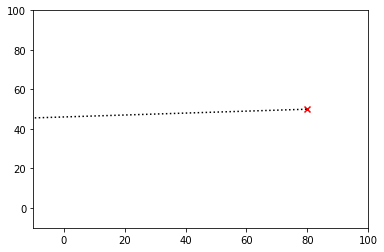

Stopped because of timeout.


<Figure size 432x288 with 0 Axes>

In [30]:
p_horizon = 20
u_horizon = 10
vg = 1*np.ones((p_horizon,1))
wg = 0.1*np.ones((p_horizon,1))
# vg = np.random.random((p_horizon,1))
# wg = np.random.random((p_horizon,1))
a = Agent(1, [0,0,np.deg2rad(45)],[80,50,np.deg2rad(45)], vg, wg, p_horizon, u_horizon)

th = 0.5
timeout = 20
while( (np.linalg.norm(a.c_state-a.g_state)>th) and timeout>0):
    a.pred_controls()
    for i in range(u_horizon):
        a.v = a.vg[i]
        a.w = a.wg[i]
        a.x_traj = []
        a.y_traj = []
        a.get_traj(i)
        a.non_hol_update()
        clear_output(wait=True)
        x,y = a.draw_circle()
        plt.plot(x,y,'b')
        plt.scatter(a.g_state[0],a.g_state[1],marker='x', color='r')
        plt.scatter(a.x_traj, a.y_traj,marker='.', color='r', s=1)
        plt.plot([a.c_state[0],a.g_state[0]],[a.c_state[1],a.g_state[1]], linestyle='dotted', c='k')
        plt.show()
        plt.xlim([-10,100])
        plt.ylim([-10,100])
#         a.v_list.append(a.vg[i])
        timeout = timeout - a.dt
plt.clf()
if(timeout <= 0):
    print("Stopped because of timeout.")